In [1]:
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
import sys
sys.path.append('../')

In [2]:
best_configs_1H = [
    ('SM_1H_K2',"CSNN"),
    ('MM_1H_K2',"CSNN"),
    ('LM_1H_K2',"CSNN"),
]
best_configs_2H = [
    ('SM_2H_K3',"CSNN"),
    ('MM_2H_K2',"CSNN"),
    ('LM_2H_K3',"CSNN"),
]
configs_1H = [
    ('SM_1H_K2', "CSNN"),
    ('SM_1H_K3', "CSNN"),
    ('SM_1H_K4', "CSNN"),
    ('SM_1H_K5', "CSNN"),
    ('MM_1H_K2', "CSNN"),
    ('MM_1H_K3', "CSNN"),
    ('MM_1H_K4', "CSNN"),
    ('MM_1H_K5', "CSNN"),
    ('LM_1H_K2', "CSNN"),
    ('LM_1H_K3', "CSNN"),
    ('LM_1H_K4', "CSNN"),
    ('LM_1H_K5', "CSNN"),
]
configs_2H = [
    ('SM_2H_K2', "CSNN"),
    ('SM_2H_K3', "CSNN"),
    ('SM_2H_K4', "CSNN"),
    ('MM_2H_K2', "CSNN"),
    ('MM_2H_K3', "CSNN"),
    ('MM_2H_K4', "CSNN"),
    ('LM_2H_K2', "CSNN"),
    ('LM_2H_K3', "CSNN"),
    ('LM_2H_K4', "CSNN"),
]
configs_3H = [
    ('SM_3H_K2', "CSNN"),
    ('MM_3H_K2', "CSNN"),
    ('LM_3H_K2', "CSNN"),
]
configs_FFSNN = [
    ("FFSNN_1H", "OTH"),
    ("FFSNN_2H", "OTH"),
    ("FFSNN_3H", "OTH"),
]
configs_CNN = [
    ("CNN_1H", "OTH"),
    ("CNN_2H", "OTH"),
    ("CNN_3H", "OTH"),
]
configs_FFNN = [
    ("FFNN_1H", "OTH"),
    ("FFNN_2H", "OTH"),
    ("FFNN_3H", "OTH"),
] 

In [3]:
studies_per_config = {}  
#for model, configs in [("CSNN Models (1H)", configs_1H), ("CSNN Models (2H)", configs_2H), ("CSNN Models (3H)", configs_3H), ("FFSNN Models", configs_FFSNN), ("CNN Models", configs_CNN), ("FFNN Models", configs_FFNN)]:
for model, configs in [("CSNN Models (1H)", best_configs_1H), ("CSNN Models (2H)", best_configs_2H), ("CSNN Models (3H)", configs_3H), ("FFSNN Models", configs_FFSNN), ("CNN Models", configs_CNN), ("FFNN Models", configs_FFNN)]:    
    studies = []
    for subconfig, db in configs:
        study = optuna.load_study(study_name=subconfig, storage=f'sqlite:///../results/results-{db}.db')
        studies.append(study)
    studies_per_config[model] = studies

list_bests_fronts = []
for i, (config, studies) in enumerate(studies_per_config.items()):
    bests_fronts = {}
    for study in studies:
        df = study.trials_dataframe() 
        best_trials = study.best_trials
        fpr_col = 'user_attrs_@global fpr'
        recall_col = 'user_attrs_@global recall'
        df = df.rename(columns={fpr_col: 'fpr', recall_col: 'recall'})
        df_best = df[df['number'].isin([trial.number for trial in best_trials])]
        df_not_best = df[~df['number'].isin([trial.number for trial in best_trials])]
        bests_fronts[study.study_name] = (df_best, df_not_best)
    list_bests_fronts.append(bests_fronts)


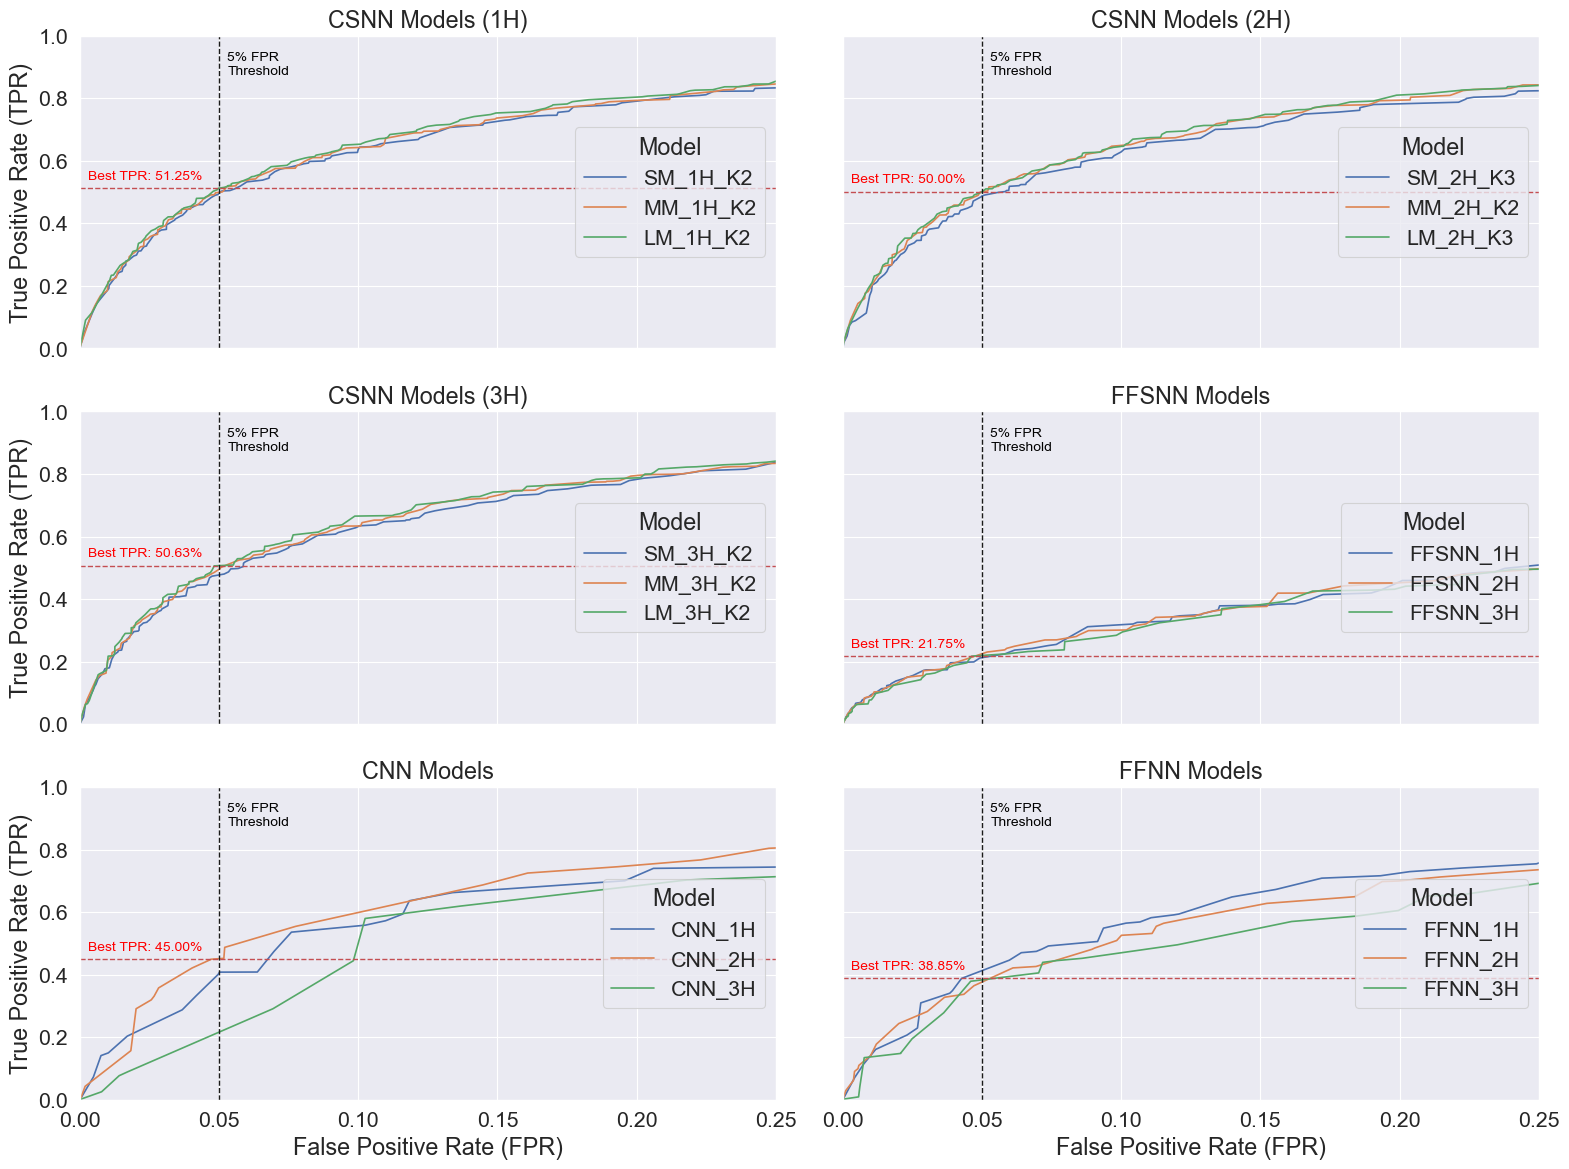

In [4]:
sns.set_theme(style="darkgrid")
sns.set_context("paper", font_scale=1.75)

fig, ax = plt.subplots(3,2, figsize=(16,12), sharex=True, sharey=True)
for i, (config, studies) in enumerate(studies_per_config.items()):
    max_recall = 0
    for study_name, (df_best, df_not_best) in list_bests_fronts[i].items():
        sns.lineplot(x='fpr', y='recall', data=df_best, label=study_name, ax=ax[i//2,i%2])
        # get the highest recall value where fpr <= 0.05
        current_max_recall = df_best[df_best['fpr'] <= 0.05]['recall'].max()
        if max_recall < current_max_recall:
            max_recall = current_max_recall
    ax[i//2,i%2].axhline(y=max_recall, color='r', linestyle='--', linewidth=1)
    ax[i//2,i%2].text(0.003, max_recall + 0.02, f'Best TPR: {max_recall*100:.2f}%', color='red', ha='left', va='bottom', fontsize=10)
    ax[i//2,i%2].axvline(x=0.05, color='k', linestyle='--', linewidth=1)
    ax[i//2,i%2].text(0.053, 0.95, '5% FPR\nThreshold', color='black', ha='left', va='top', fontsize=10)
    ax[i//2,i%2].set_title(config)
    ax[i//2,i%2].set_xlim(0, 0.25)
    ax[i//2,i%2].set_ylim(0, 1)
    ax[i//2,i%2].set_xlabel('False Positive Rate (FPR)')
    ax[i//2,i%2].set_ylabel('True Positive Rate (TPR)')
    ax[i//2,i%2].legend(loc='right', title="Model", ncol=2 if len(list_bests_fronts[i])>8 else 1)
plt.tight_layout()
plt.show()

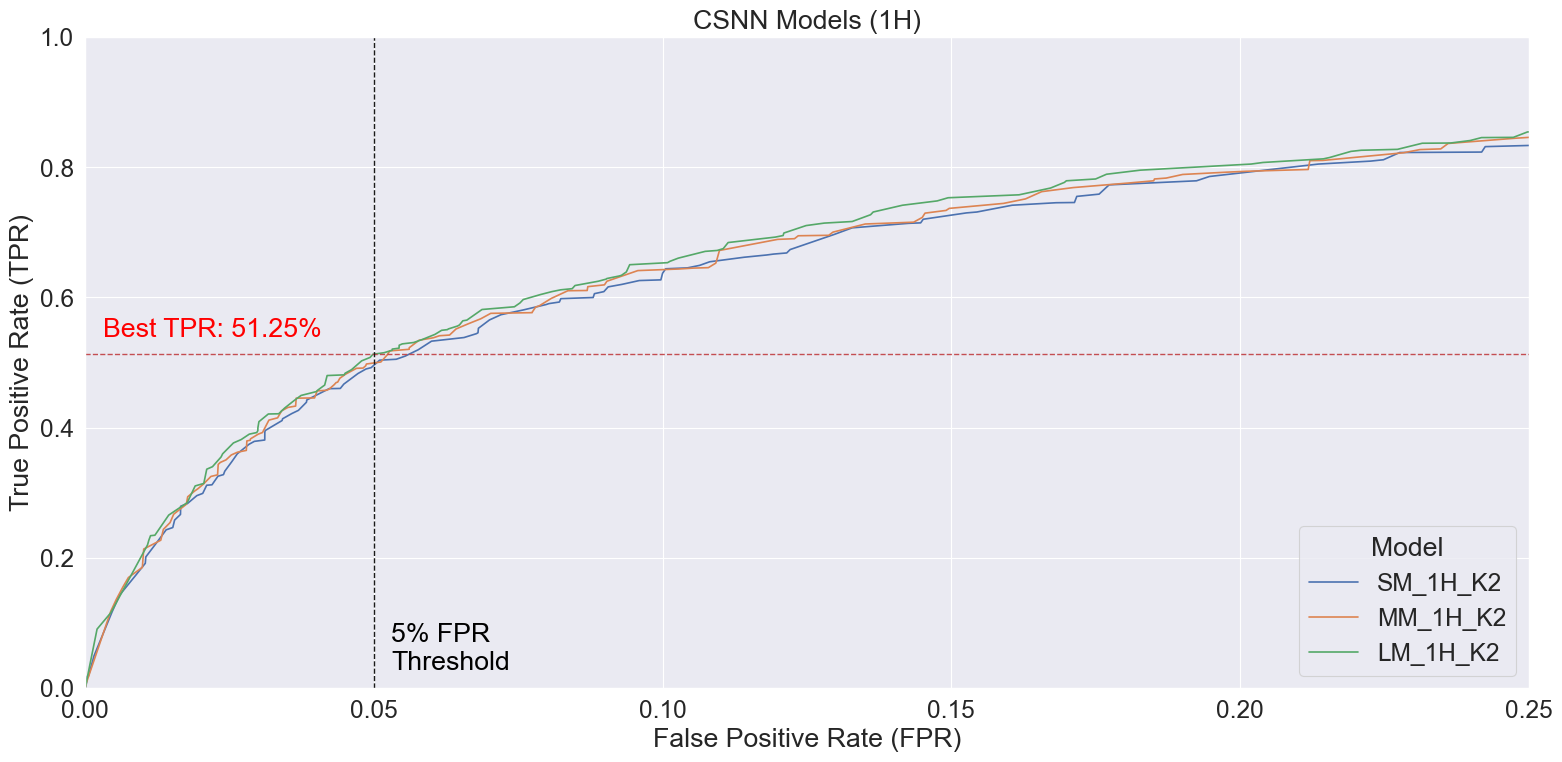

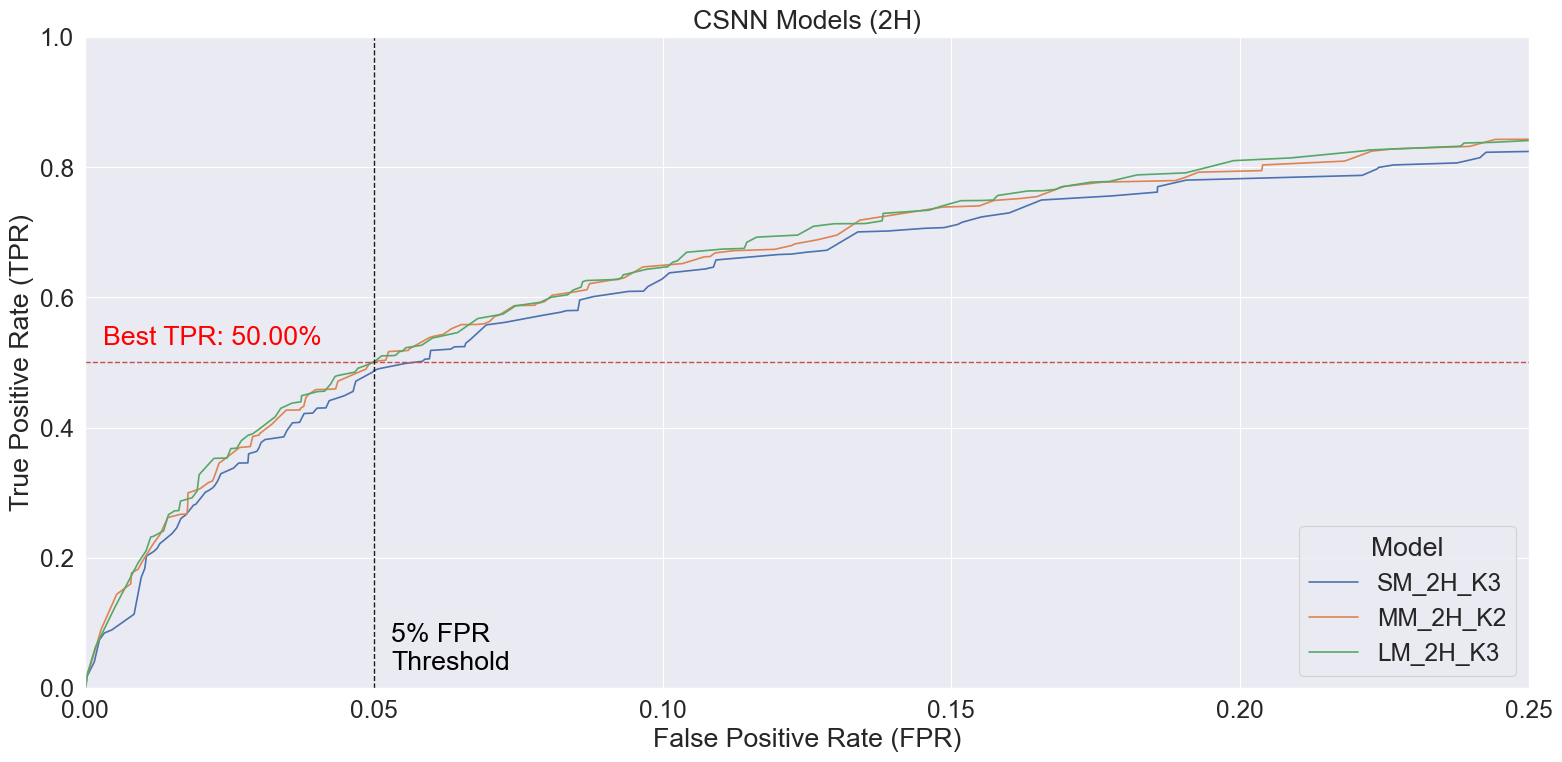

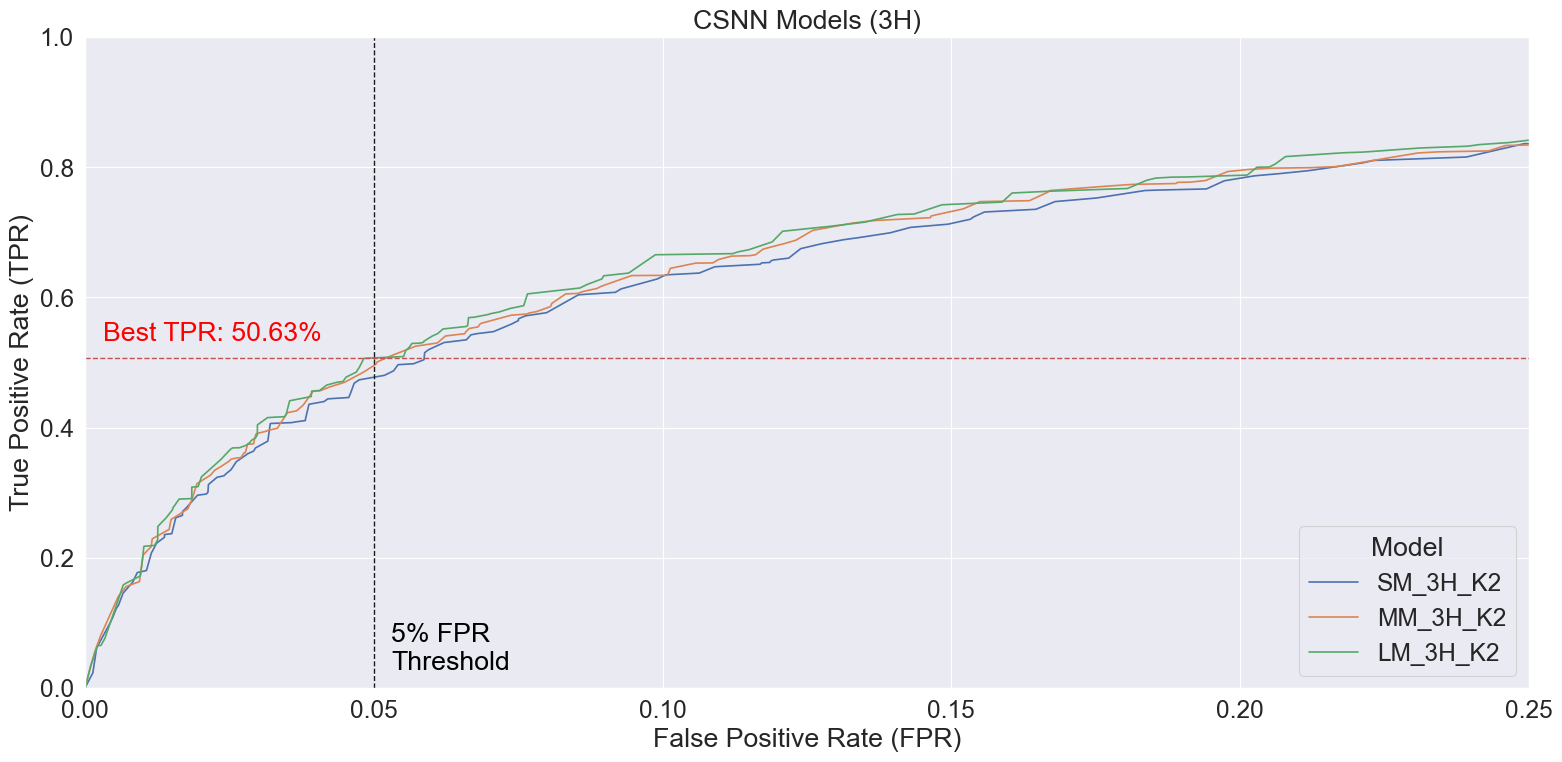

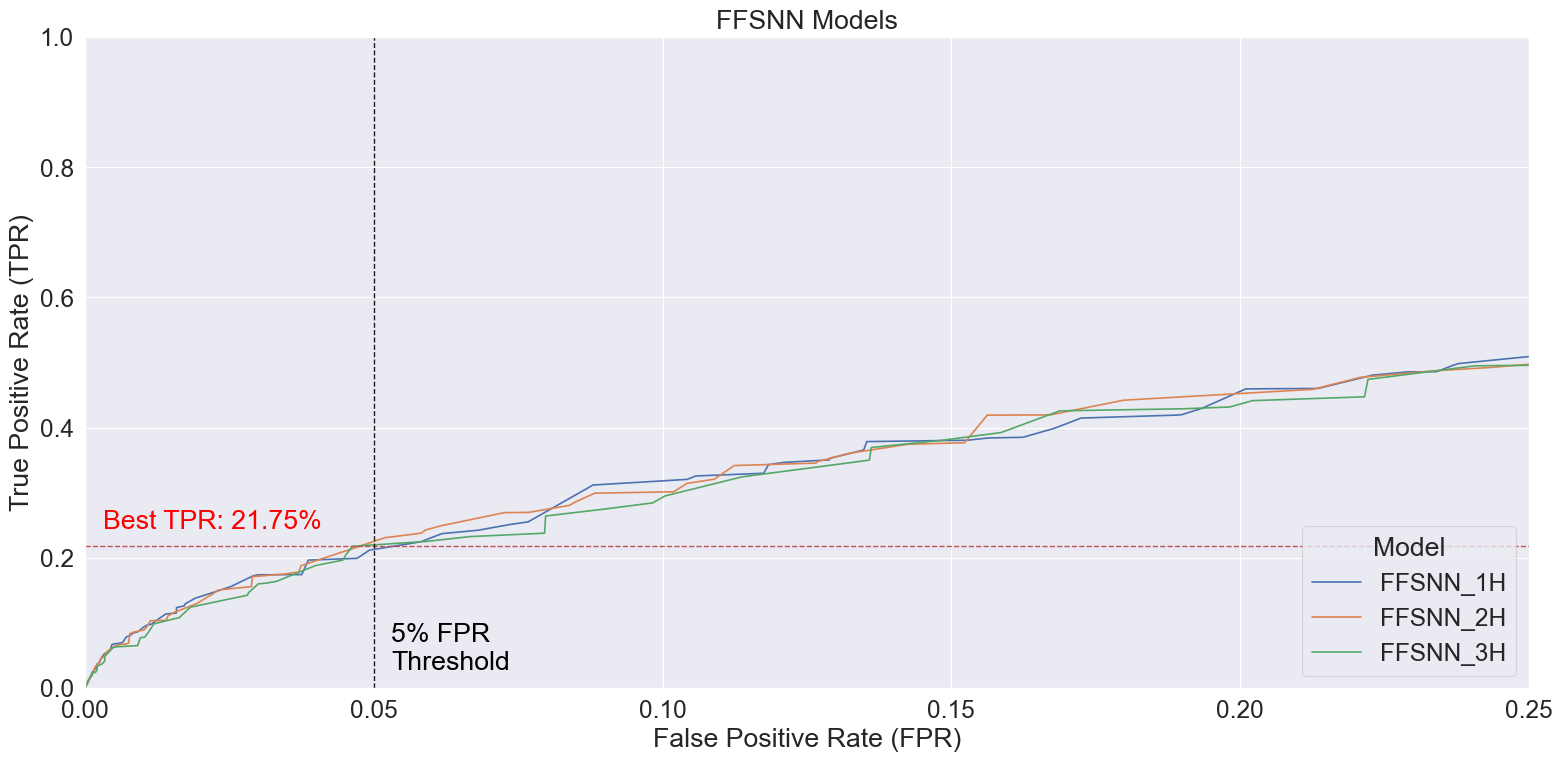

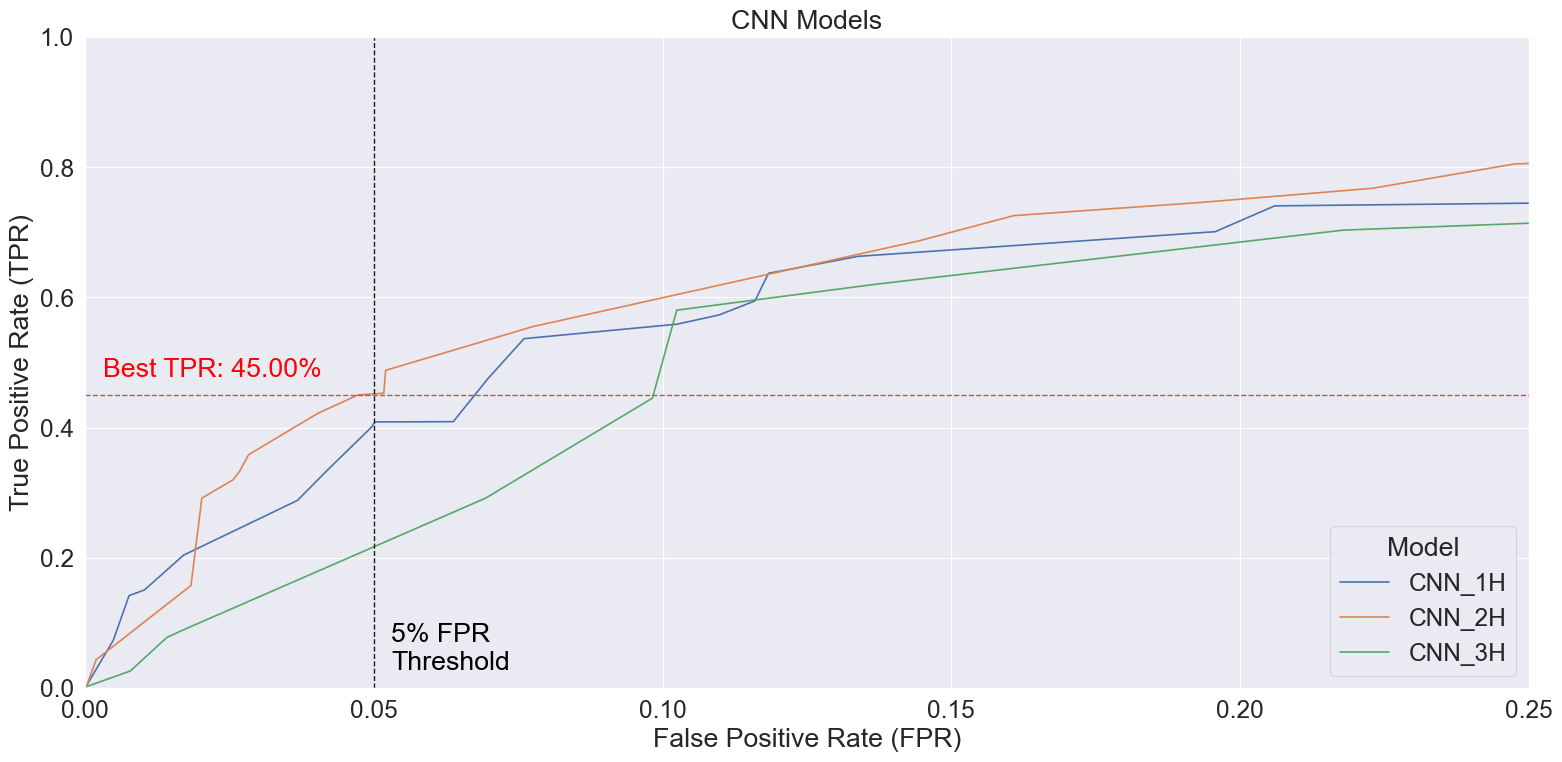

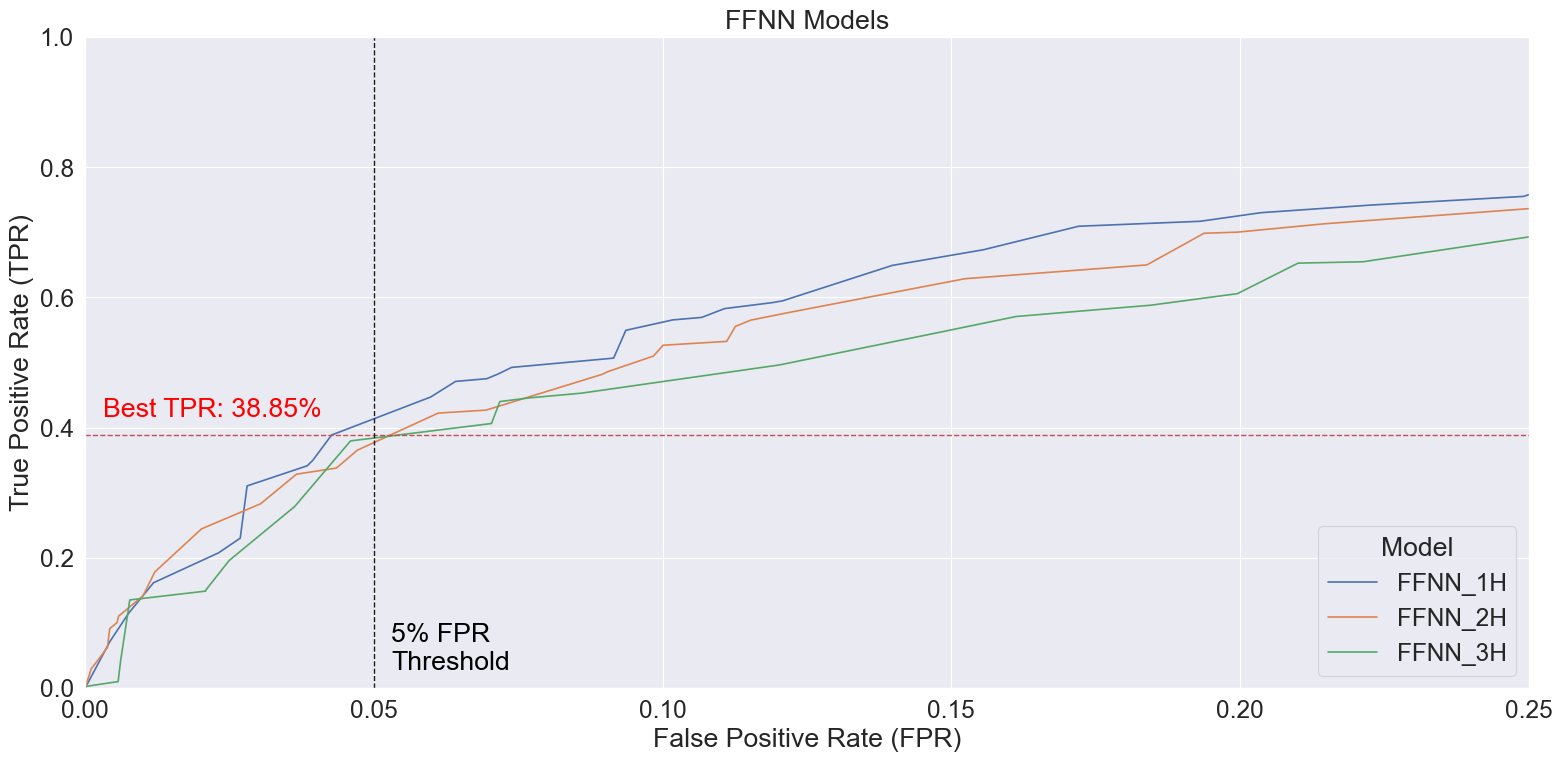

In [5]:
sns.set_theme(style="darkgrid")
sns.set_context("paper", font_scale=2)

for i, (config, studies) in enumerate(studies_per_config.items()):
    fig, ax = plt.subplots(1,1, figsize=(16,8))
    max_recall = 0
    for study_name, (df_best, df_not_best) in list_bests_fronts[i].items():
        sns.lineplot(x='fpr', y='recall', data=df_best, label=study_name, ax=ax)
        # get the highest recall value where fpr <= 0.05
        current_max_recall = df_best[df_best['fpr'] <= 0.05]['recall'].max()
        if max_recall < current_max_recall:
            max_recall = current_max_recall
    ax.axhline(y=max_recall, color='r', linestyle='--', linewidth=1)
    ax.text(0.003, max_recall + 0.02, f'Best TPR: {max_recall*100:.2f}%', color='red', ha='left', va='bottom')
    ax.axvline(x=0.05, color='k', linestyle='--', linewidth=1)
    ax.text(0.053, 0.1, '5% FPR\nThreshold', color='black', ha='left', va='top')
    ax.set_title(config)
    ax.set_xlim(0, 0.25)
    ax.set_ylim(0, 1)
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.legend(loc='lower right', title="Model", ncol=2 if len(list_bests_fronts[i])>8 else 1)
    plt.tight_layout()
    plt.show()